# Imports

In [545]:
import pandas as pd
import seaborn as sns

import re
import pickle
from unidecode import unidecode
import category_encoders as ce

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from joypy import joyplot

from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from boruta import BorutaPy
from sklearn import linear_model as lm
import xgboost

import warnings
warnings.filterwarnings("ignore")

## Functions

In [546]:
def extract_power(re_string):
    hp = 'sem informação'
    if re_string is None:
        pass
    else:
         hp = re_string.group(0)
    return hp

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y,yhat)
    mape = mt.mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mt.mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])

def train_preparation(x_train_prep, y_train_prep):
    # transforma response variable
    y_train_prep = pd.DataFrame(np.log1p(y_train_prep))

    # standarization
    sc = pp.StandardScaler()
    y_train_norm_prep = sc.fit_transform(y_train_prep)
    pickle.dump(sc, open('parameters/sc_response.pkl','wb'))
    
    sc = pp.StandardScaler()
    x_train_prep['km_media_ano_em_1k_km'] = sc.fit_transform(x_train_prep[['km_media_ano_em_1k_km']])
    pickle.dump(sc, open('parameters/sc_km_media_ano.pkl','wb'))

    # rescaling
    rs = pp.RobustScaler()

    x_train_prep['ano_de_fabricacao'] = rs.fit_transform(x_train_prep[['ano_de_fabricacao']])
    pickle.dump(rs, open('parameters/rs_ano_de_fabricacao.pkl','wb'))

    x_train_prep['ano_modelo'] = rs.fit_transform(x_train_prep[['ano_modelo']])
    pickle.dump(rs, open('parameters/rs_ano_modelo.pkl','wb'))

    x_train_prep['odometro'] = rs.fit_transform(x_train_prep[['odometro']])
    pickle.dump(rs, open('parameters/rs_odometro.pkl','wb'))

    # encodings
    ## one hot encode

    # blindado
    x_train_prep['blindado'] = x_train_prep['blindado'].replace({'S':1, 'N':0})

    # tipo_vendedor
    x_train_prep['tipo_vendedor'] = x_train_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

    # tipo_anuncio
    oe = pp.OneHotEncoder(sparse=False,handle_unknown='ignore')
    x_train_prep['tipo_anuncio'] = x_train_prep['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
    cols_dummies = oe.fit_transform(x_train_prep['tipo_anuncio'].values.reshape(-1,1))
    x_train_prep[oe.categories_[0]] = cols_dummies
    pickle.dump(oe,open(f'parameters/oe_tipo_anuncio.pkl', 'wb'))

    x_train_prep['cambio'] = x_train_prep['cambio'].map({'Manual':0,
                                                'Automática Sequencial':1, 
                                                'Semi-automática':2,
                                                'CVT':3,
                                                'Automatizada':4,
                                                'Automática':4,
                                                'Automatizada DCT':5
                                                })

    x_train_prep['num_portas'] = x_train_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

    # target encode
    for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
        te = ce.TargetEncoder(cols=[att],).fit(x_train_prep, y_train_norm_prep)
        pickle.dump(te, open(f'parameters/te_{att}.pkl','wb'))
        x_train_prep = te.transform(x_train_prep)

    # frequency encode
    for att in ['marca', 'modelo','versao','cilindradas']:
        fe =  ce.CountEncoder(cols=[att], normalize=True).fit(x_train_prep)
        pickle.dump(fe,open(f'parameters/fe_{att}.pkl', 'wb'))
        x_train_prep = fe.transform(x_train_prep)
    
    return x_train_prep, y_train_prep

def test_preparation(x_test_prep, y_test_prep):
   
    # Transformando variável resposta
    y_test_prep = pd.DataFrame(np.log1p(y_test_prep))
    
    # Standarization
    sc = pickle.load(open('parameters/sc_km_media_ano.pkl','rb'))
    x_test_prep['km_media_ano_em_1k_km'] = sc.transform(x_test_prep[['km_media_ano_em_1k_km']])

    # Rescaling
    rs = pickle.load(open('parameters/rs_ano_de_fabricacao.pkl','rb'))
    x_test_prep['ano_de_fabricacao'] = rs.transform(x_test_prep[['ano_de_fabricacao']])

    rs = pickle.load(open('parameters/rs_ano_modelo.pkl','rb'))
    x_test_prep['ano_modelo'] = rs.transform(x_test_prep[['ano_modelo']])

    rs = pickle.load(open('parameters/rs_odometro.pkl','rb'))
    x_test_prep['odometro'] = rs.transform(x_test_prep[['odometro']])

    # Encode
    ## One Hot Encode
    # blindado
    x_test_prep['blindado'] = x_test_prep['blindado'].replace({'S':1, 'N':0})

    # tipo_vendedor
    x_test_prep['tipo_vendedor'] = x_test_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

    # tipo_anuncio
    oe = pickle.load(open(f'parameters/oe_tipo_anuncio.pkl', 'rb'))
    x_test_prep['tipo_anuncio'] = x_test_prep['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
    cols_dummies = oe.transform(x_test_prep['tipo_anuncio'].values.reshape(-1,1))
    x_test_prep[oe.categories_[0]] = cols_dummies

    x_test_prep['cambio'] = x_test_prep['cambio'].map({'Manual':0,
                                                'Automática Sequencial':1, 
                                                'Semi-automática':2,
                                                'CVT':3,
                                                'Automatizada':4,
                                                'Automática':4,
                                                'Automatizada DCT':5
                                                })

    x_test_prep['num_portas'] = x_test_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

    ## Target Encode
    for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
        te = pickle.load(open(f'parameters/te_{att}.pkl','rb'))
        x_test_prep = te.transform(x_test_prep)

    ## Frequency Encode

    for att in ['marca', 'modelo','versao','cilindradas']:
        fe = pickle.load(open(f'parameters/fe_{att}.pkl', 'rb'))
        x_test_prep = fe.transform(x_test_prep)
        
    return x_test_prep, y_test_prep

def cross_validation_k_fold(X, y, features_selected, model_name, model, k):

    cv_results = pd.DataFrame()
    
    k_fold = ms.KFold(n_splits=k)

    ## Para cada k_fold
    for i, (train_index, test_index) in enumerate(k_fold.split(X)):

        # Separar treino e teste
        X_train_cross, y_train_cross = X.iloc[train_index], y.iloc[train_index]

        X_test_cross, y_test_cross = X.iloc[test_index], y.iloc[test_index]

        ## Data Preparation
        # Transformar treino
        X_train_cross, y_train_cross = train_preparation(X_train_cross, y_train_cross)

        # Transformar teste
        X_test_cross, y_test_cross = test_preparation(X_test_cross, y_test_cross)

        ## Treinar modelo
        model.fit(X_train_cross[features_selected], y_train_cross)

        ## Predict
        y_pred_cross = model.predict(X_test_cross[features_selected])

        ## Performance
        result_model = ml_error(model_name, np.expm1(y_test_cross), np.expm1(y_pred_cross))

        ## Salvar resultado
        cv_results = pd.concat([cv_results, result_model], axis=0)
        
    cv_values = round(cv_results.mean(),3)
    cv_std = round(cv_results.std(),3)
    return pd.DataFrame({'Model': model_name,
                 'MAE': cv_values['MAE'].astype(str) + ' +/- ' + cv_std['MAE'].astype(str),
                 'MAPE': cv_values['MAPE'].astype(str) + ' +/- ' + cv_std['MAPE'].astype(str),
                 'RMSE': cv_values['RMSE'].astype(str) + ' +/- ' + cv_std['RMSE'].astype(str)}, index=[0])

# Load Dataset

In [547]:
df = pd.read_csv('datasets/treino.csv')

In [548]:
df.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,...,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,...,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,NaN,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,255164.344178


# Data Description

In [549]:
df.columns.tolist()

['ID',
 'num_fotos',
 'marca',
 'modelo',
 'versao',
 'ano_de_fabricacao',
 'ano_modelo',
 'odometro',
 'cambio',
 'num_portas',
 'tipo',
 'blindado',
 'cor',
 'tipo_vendedor',
 'cidade_vendedor',
 'estado_vendedor',
 'tipo_anuncio',
 'entrega_delivery',
 'troca',
 'elegivel_revisao',
 'attr_veiculo_aceita_troca',
 'attr_veiculo_único_dono',
 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
 'attr_veiculo_ipva_pago',
 'attr_veiculo_licenciado',
 'attr_veiculo_garantia_de_fábrica',
 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
 'attr_veiculo_alienado',
 'preco']

## Data Dimension

In [550]:
print(f'Número de linhas: {df.shape[0]}')
print(f'Número de colunas: {df.shape[1]}')

Número de linhas: 39446
Número de colunas: 29


## Data Types

In [551]:
df.dtypes

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Check NAs

In [552]:
df.isna().sum()

ID                                                                0
num_fotos                                                       237
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

## Filtering Data

In [553]:
# removendo colunas que possuem NA's + id
 
cols_drop = [
 'ID',
 'num_fotos',
 'attr_veiculo_aceita_troca',
 'attr_veiculo_único_dono',
 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
 'attr_veiculo_ipva_pago',
 'attr_veiculo_licenciado',
 'attr_veiculo_garantia_de_fábrica',
 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
 'attr_veiculo_alienado']

df = df.drop(columns=cols_drop)

## Descriptive Statistical

Objetivos: 
1. Ganhar conhecimento de negócio 
2. Detectar erros nos dados


### Numerical Attributes

In [554]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [555]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
1,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
2,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
3,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
4,preco,7258.159943,1.359813e+06,1.352555e+06,133385.874348,114307.970618,82383.927619,2.226090,12.357643


### Categorical Attributes

- "entrega_delivery", "troca" e "elegivel_revisao" parecem ser variáveis com baixo poder preditivo pois sua distribuição em relação ao preção é bem parecida para cada uma de suas labels

In [556]:
for col in cat_attributes.columns.tolist():
    elements = df[col].unique().tolist()
    n_elements = len(elements)
    
    print(f'{col}: {n_elements}')

marca: 41
modelo: 473
versao: 2058
cambio: 7
tipo: 8
blindado: 2
cor: 8
tipo_vendedor: 2
cidade_vendedor: 648
estado_vendedor: 25
tipo_anuncio: 4
entrega_delivery: 2
troca: 2
elegivel_revisao: 1


#### Marca

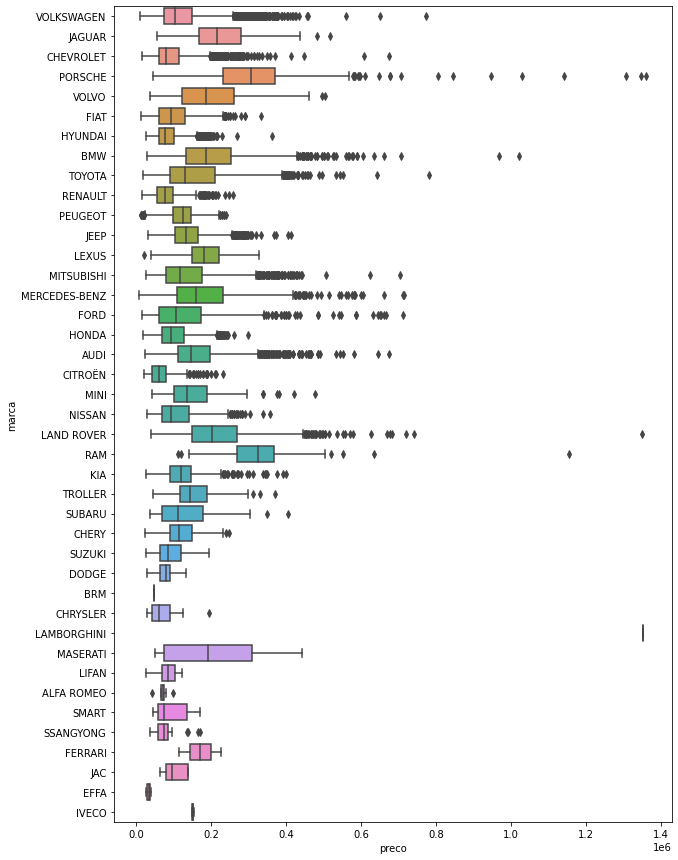

In [557]:
plt.figure(figsize=(10,15))
sns.boxplot(x='preco' , y='marca' , data=df);

#### Cambio

<AxesSubplot:xlabel='cambio', ylabel='preco'>

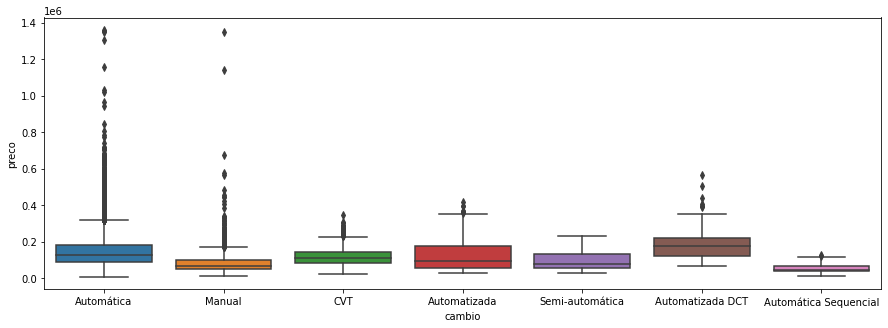

In [558]:
plt.figure(figsize=(15,5))
sns.boxplot(x='cambio' , y='preco' , data=df)

#### Tipo

<AxesSubplot:xlabel='tipo', ylabel='preco'>

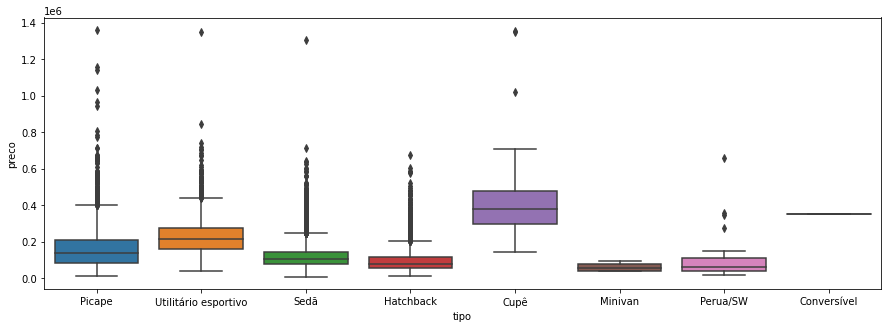

In [559]:
plt.figure(figsize=(15,5))
sns.boxplot(x='tipo' , y='preco' , data=df)

#### Blindado

<AxesSubplot:xlabel='blindado', ylabel='preco'>

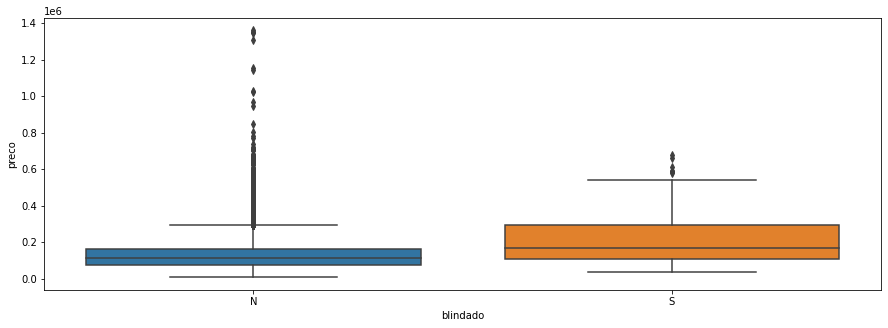

In [560]:
plt.figure(figsize=(15,5))
sns.boxplot(x='blindado' , y='preco' , data=df)

#### Cor

<AxesSubplot:xlabel='cor', ylabel='preco'>

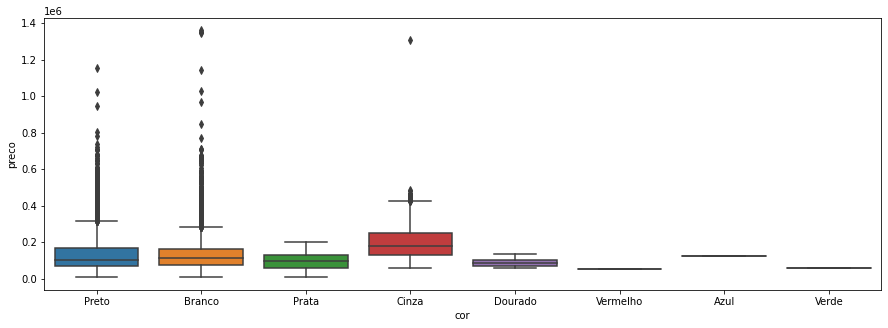

In [561]:
plt.figure(figsize=(15,5))
sns.boxplot(x='cor' , y='preco' , data=df)

#### Tipo Vendedor

<AxesSubplot:xlabel='tipo_vendedor', ylabel='preco'>

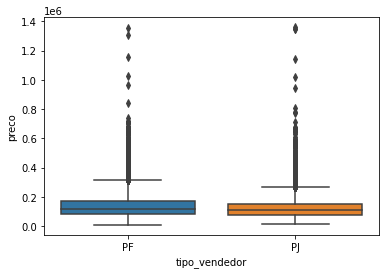

In [562]:
sns.boxplot(x='tipo_vendedor' , y='preco' , data=df)

#### Estado Vendedor

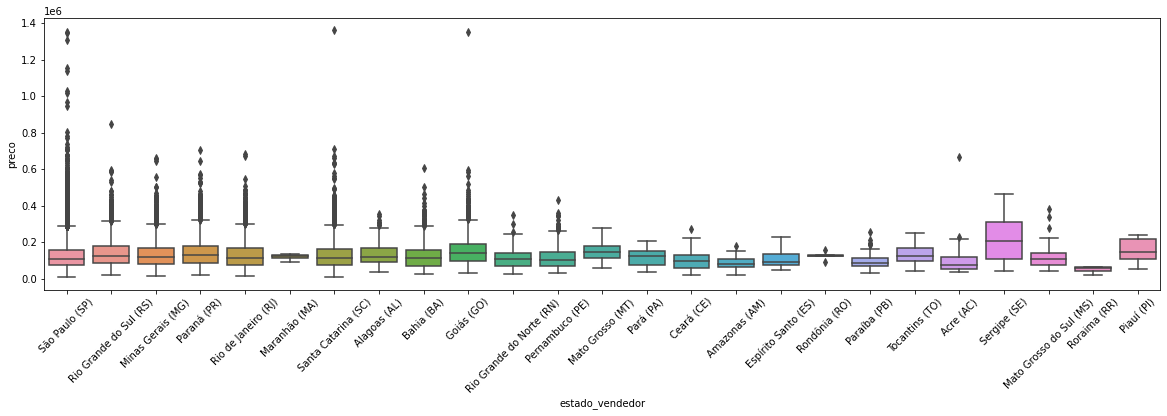

In [563]:
plt.figure(figsize=(20,5))
sns.boxplot(x='estado_vendedor' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Entrega Delivey

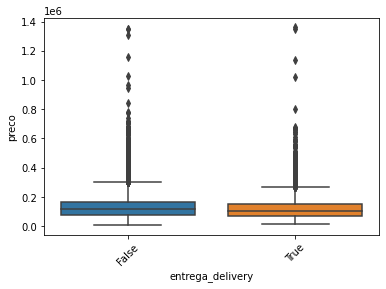

In [564]:
sns.boxplot(x='entrega_delivery' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Troca

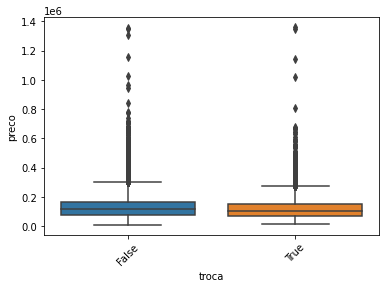

In [565]:
sns.boxplot(x='troca' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Elegível Revisão

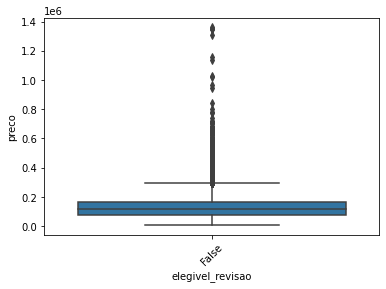

In [566]:
sns.boxplot(x='elegivel_revisao' , y='preco' , data=df)
plt.xticks(rotation=45);

# Feature Engineering

In [567]:
df4 = df.copy()

## Feature Creation

In [568]:
# extraindo as cilindradas da coluna versão
df4['cilindradas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

# extraindo válvulas da coluna versão
df4['valvulas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

# extraindo combustível da coluna versão
df4['combustivel'] = df4['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                   'FLEX' if 'FLEX'     in x else 
                                                   'DIESEL' if 'DIESEL'   in x else 
                                                   'ÁLCOOL' if 'ÁLCOOL' in x else
                                                   'HÍBRIDO' if 'HYBRID' in x else
                                                   'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

# removendo features derivadas da coluna original
df4['versao'] = df4.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

# retirando acentos, substituindo letras maiúsculas e espaços
df4['cidade_vendedor'] = df4['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

# extraindo estado
df4['estado_vendedor'] = df4['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

# criando feature de localidade
df4['localidade_vendedor'] = df4['cidade_vendedor'] + "_" + df4['estado_vendedor']

# criando feature de km médio rodado por ano
df4['km_media_ano_em_1k_km'] = df4['odometro']/np.round(2023 - df4['ano_modelo'] + 0.51,0)
# arredondando e escalando por 1000 km
df4['km_media_ano_em_1k_km'] = round(df4['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

# criando feature de agregação do veículo com marca, modelo, km_media e localidade
df4['veiculo'] = df4['marca'].astype(str) + "_" + df4['modelo'].astype(str) + "_" + df4['km_media_ano_em_1k_km'].astype(str)

In [569]:
df4.sample(3)

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,...,entrega_delivery,troca,elegivel_revisao,preco,cilindradas,valvulas,combustivel,localidade_vendedor,km_media_ano_em_1k_km,veiculo
17475,MERCEDES-BENZ,C 180,CGI AVANTGARDE TURBO 4P,2013,2017.0,86537.0,Automática,4,Sedã,N,...,True,True,False,115301.079460,1.6,16V,GASOLINA,sao_jose_do_rio_preto_SP,12,MERCEDES-BENZ_C 180_12
23741,PEUGEOT,2008,ALLURE PACK 4P,2021,2021.0,21870.0,Automática,4,Sedã,N,...,False,False,False,176886.242438,1.6,16V,FLEX,fortaleza_MG,7,PEUGEOT_2008_7
11680,CHEVROLET,TRACKER,MPFI LTZ 4X2 4P,2013,2015.0,92549.0,Automática,4,Sedã,N,...,False,False,False,84263.019015,1.8,16V,FLEX,presidente_prudente_SP,10,CHEVROLET_TRACKER_10


# Exploratory Data Analysis

Objetivos:
1. Ganhar experiência de Negócio
2. Validar Hióteses de Negócios
3. Perceber variáveis que são importantes para o modelo
    - Não podemos confiar 100% na seleção de features

In [570]:
df5 = df4.copy()

## Univariate Analysis

### Response Variable

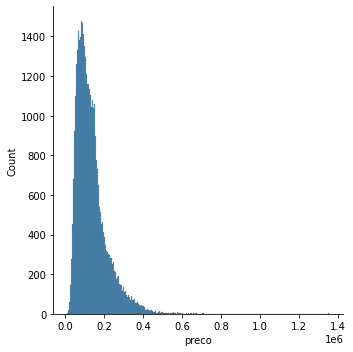

In [571]:
sns.displot(df5['preco'])

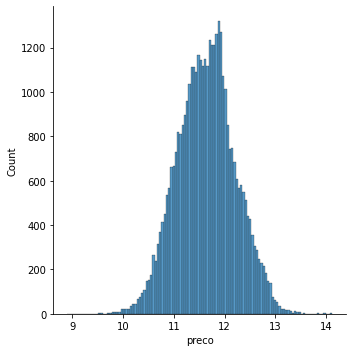

In [572]:
sns.displot(np.log1p(df5['preco']));

### Numerical Variable

**Scalers sugeridos:**

| Atributo               | Rescaling  |
| ---------------------- | ------------- |
|**Ano de Fabricação:** | Robust Scaler |
|**Ano do Modelo:** | Robust Scaler|
|**Odometro:** | Robust Scaler|
|**Número de Portas:** | Ordinal Encode|

In [573]:
num_attributes = df5.select_dtypes(include=['int64','float64'])
cat_attributes = df5.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### Ano de Fabricação

- Não possui distribuição normal e possui muitos outliers
- Rescaling: **ROBUST SCALER**

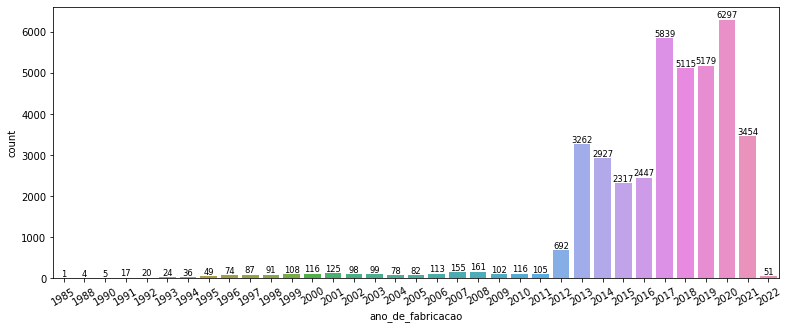

In [574]:
plt.figure(figsize=(13,5))
g = sns.countplot(x='ano_de_fabricacao', data=df5)
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='small',fmt='%.0f')
plt.xticks(rotation=30);

#### Ano do modelo

- Não possui distribuição normal e possui outliers
- Rescaling: **ROBUST SCALER**

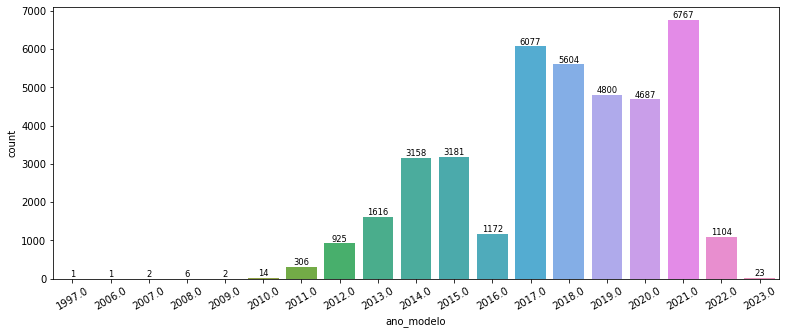

In [575]:
plt.figure(figsize=(13,5))
g = sns.countplot(x='ano_modelo', data=df5)
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='small',fmt='%.0f')
plt.xticks(rotation=30);

#### Odometro

- Não possui distribuição normal e possui outliers
- Rescaling: **ROBUST SCALER**

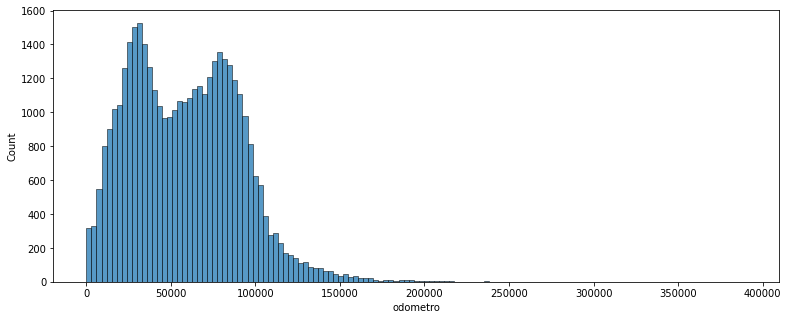

In [576]:
plt.figure(figsize=(13,5))
g = sns.histplot(x='odometro', data=df5)

#### Número de Portas

- Variável numérica com poucos labels
- Transformar em variável categórica e utilizar o **ORDINAL ENCONDING**

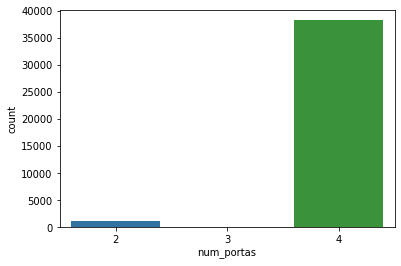

In [577]:
sns.countplot(x='num_portas', data=df5);

### Categorical Variables

####  Marca

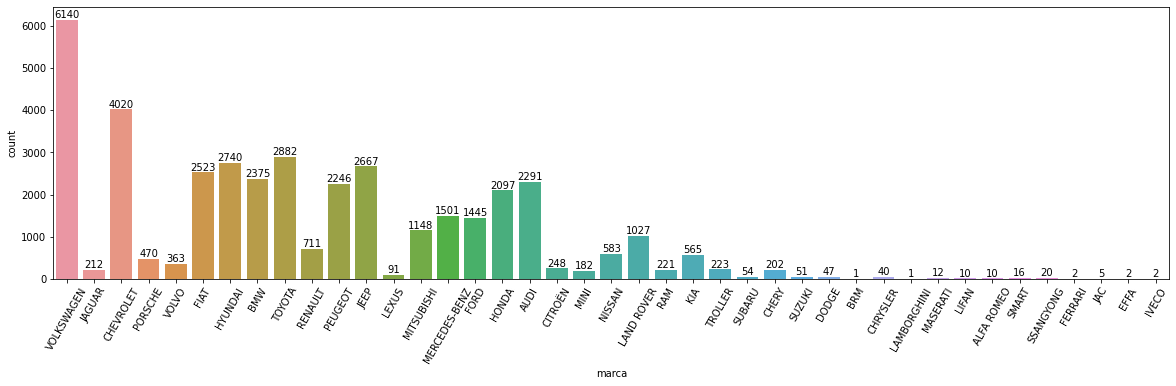

In [578]:
plt.figure(figsize=(20,5))
g = sns.countplot(x = 'marca', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=60);

#### Cambio

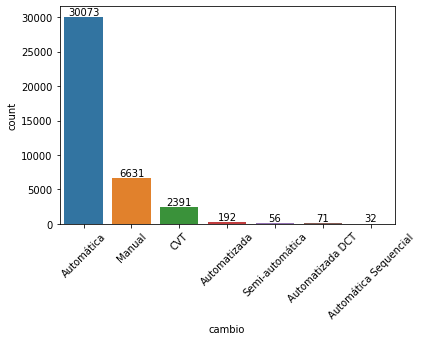

In [579]:
g = sns.countplot(x = 'cambio', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Tipo

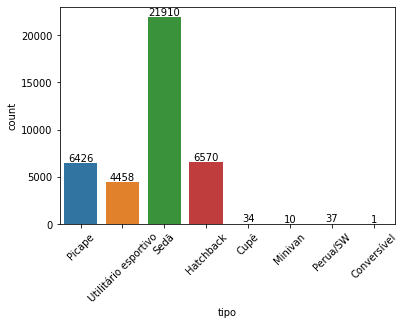

In [580]:
g = sns.countplot(x = 'tipo', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Blindado

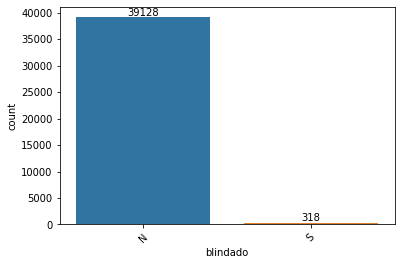

In [581]:
g = sns.countplot(x = 'blindado', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Cor

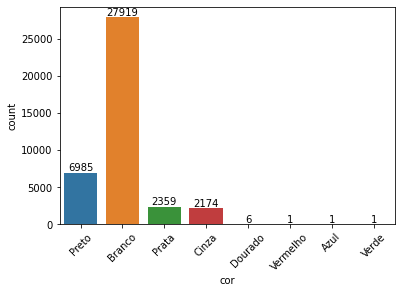

In [582]:
g = sns.countplot(x = 'cor', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Tipo Vendedor

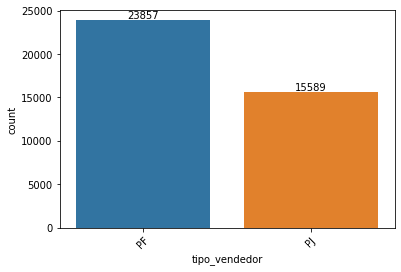

In [583]:
g = sns.countplot(x = 'tipo_vendedor', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Entrega Delivery

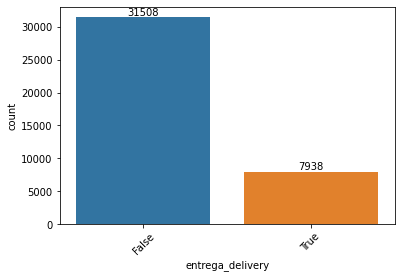

In [584]:
g = sns.countplot(x = 'entrega_delivery', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Troca

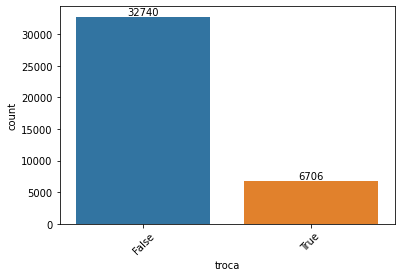

In [585]:
g = sns.countplot(x = 'troca', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Elegível Revisão

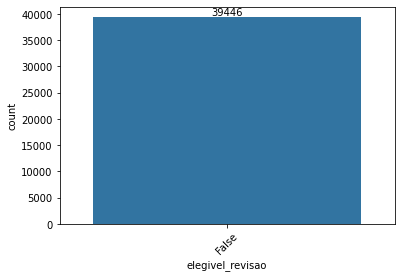

In [586]:
g = sns.countplot(x = 'elegivel_revisao', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

## Bivariate Analysis

**Encodes sugeridos**

| Atributo                | Encode          |
| ----------------------- | --------------- |
| **Marca:**              | Frequency Encode| 
| **Modelo:**             | Frequency Encode| 
| **Versão:**             | Frequency Encode| 
| **Câmbio:**             | Ordinal Enconde| 
| **Tipo:**               | Target Encode| 
| **Blindado:**           | One Hot Encode| 
| **Cor:**                | Target Encode| 
| **Tipo de Vendedor:**   | One Hot Encode| 
| **Cidade do Vendedor:** | Target Encode| 
| **Tipo de Anúncio:**    | One Hot Encode| 
| **Entrega Delivery:**   | One Hot Encode| 
| **Cilindradas:**        | Frequency Encode| 
| **Válvulas:**           | Target Encode| 
| **Combustível:**        | Target Encode| 


In [587]:
for col in cat_attributes.columns.tolist():
    print( f'{col}: {cat_attributes[col].unique().shape[0]}')

marca: 41
modelo: 473
versao: 1716
cambio: 7
tipo: 8
blindado: 2
cor: 8
tipo_vendedor: 2
cidade_vendedor: 648
estado_vendedor: 25
tipo_anuncio: 4
entrega_delivery: 2
troca: 2
elegivel_revisao: 1
cilindradas: 47
valvulas: 12
combustivel: 6
localidade_vendedor: 1140
km_media_ano_em_1k_km: 40
veiculo: 3816


#### Marca

- Variável com muitos labels
- Entende-se que pode oferta e demanda, quanto mais carros vendidos de determinada marca, menor o preço
- Enconding: **Frequency Encoding**

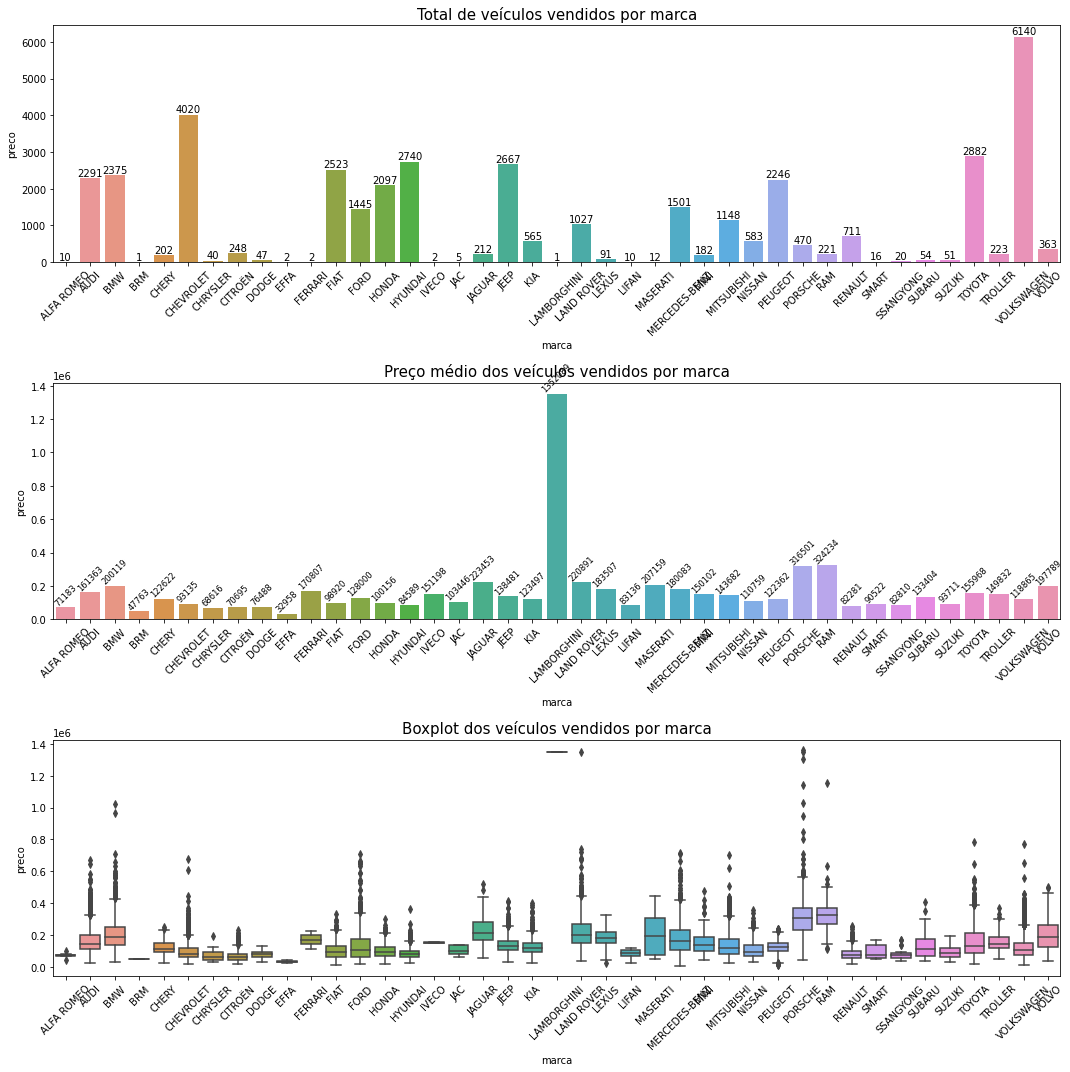

In [588]:
plt.figure(figsize=(15,15))
grid = gridspec.GridSpec(3,1)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por marca', fontsize=15)
aux = df5[['marca','preco']].groupby('marca').count().reset_index().sort_values(by='marca')
g = sns.barplot(x='marca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[1,0])
plt.title('Preço médio dos veículos vendidos por marca', fontsize=15)
aux = df5[['marca','preco']].groupby('marca').mean().reset_index().sort_values(by='marca')
g = sns.barplot(x='marca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[2,0])
plt.title('Boxplot dos veículos vendidos por marca', fontsize=15)
aux = df5.sort_values(by='marca')
sns.boxplot(x='marca', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Modelo

- Variável com várias labels
- Encoding: **Frequency Encoding**

In [589]:
print('Total de modelo diferentes: {}'.format(df5['modelo'].unique().shape[0]))

Total de modelo diferentes: 473


#### Versão

- Variável com várias labels
- Encoding: **Frequency Encode**

In [590]:
print('Total de versões diferentes: {}'.format(df5['versao'].unique().shape[0]))

Total de versões diferentes: 1716


#### Cambio

- Cambios com complexidades distintas
- Rescaling: **Ordinal Enconding** pela mediana dos preços uma vez que traduz a complexidade do cambio

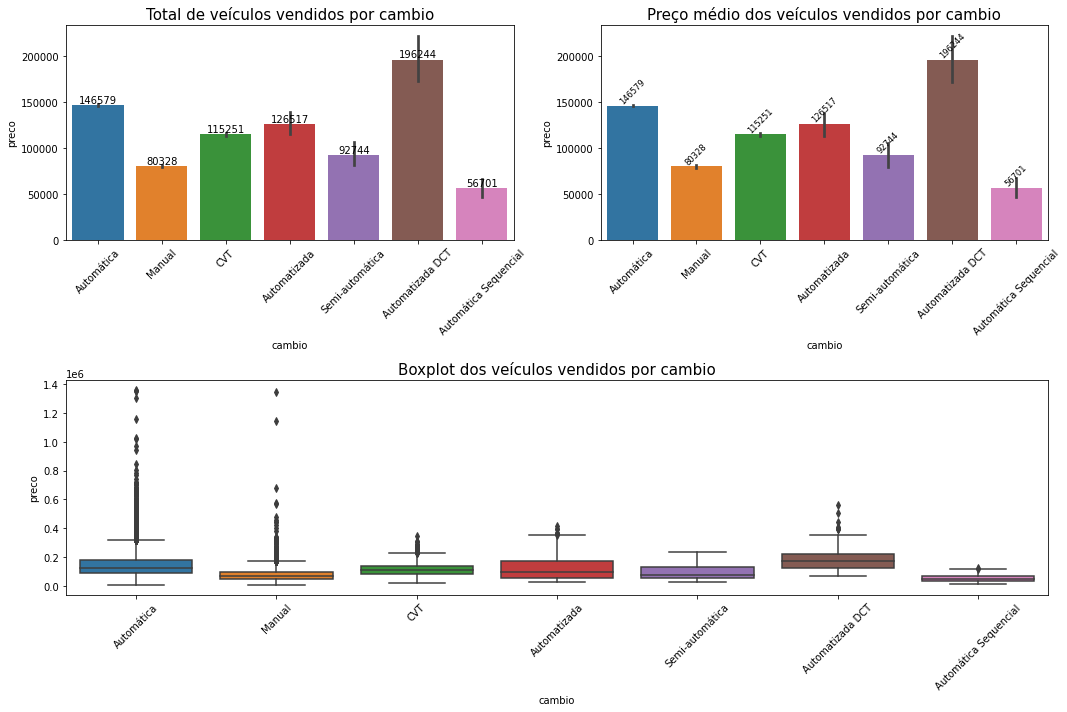

In [591]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cambio', fontsize=15)
aux = df5[['cambio','preco']].groupby('cambio').count().reset_index().sort_values(by='cambio')
g = sns.barplot(x='cambio', y = 'preco', data=df5)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cambio', fontsize=15)
aux = df5[['cambio','preco']].groupby('cambio').mean().reset_index().sort_values(by='cambio')
g = sns.barplot(x='cambio', y = 'preco', data=df5)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cambio', fontsize=15)
aux = df5.sort_values(by='cambio')
sns.boxplot(x='cambio', y = 'preco', data=df5)
plt.xticks(rotation=45);

plt.tight_layout()

#### Tipo

- Média de preços bem definida entre os tipos
- Encoding: **Tareget Encoding**

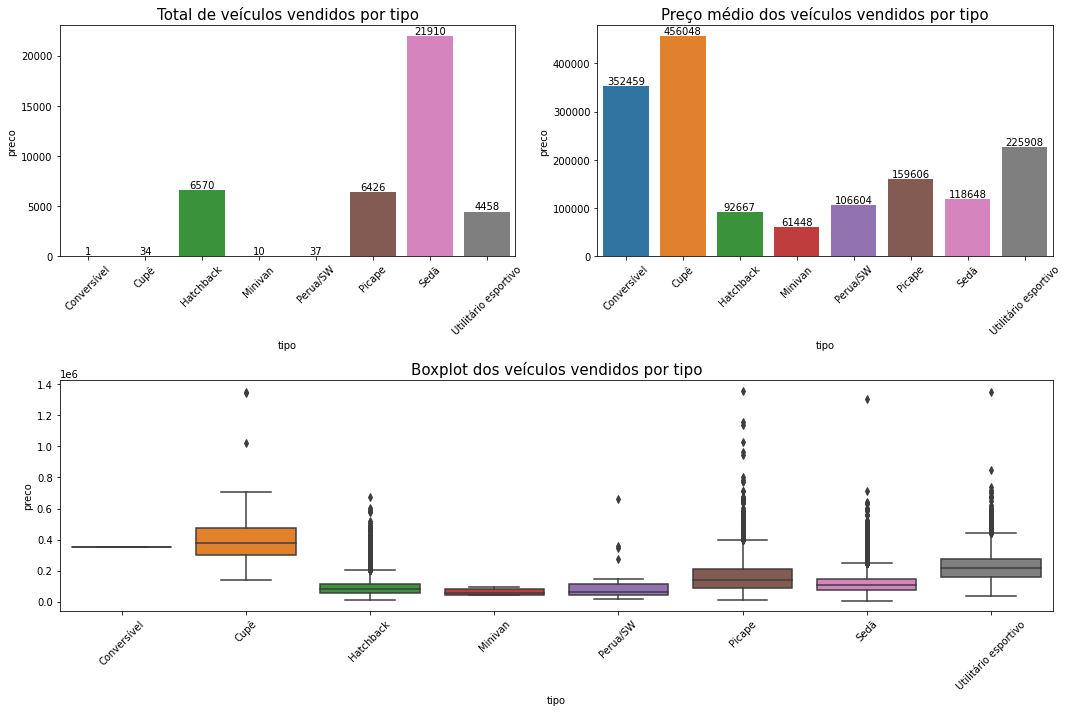

In [592]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo', fontsize=15)
aux = df5[['tipo','preco']].groupby('tipo').count().reset_index().sort_values(by='tipo')
g = sns.barplot(x='tipo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo', fontsize=15)
aux = df5[['tipo','preco']].groupby('tipo').mean().reset_index().sort_values(by='tipo')
g = sns.barplot(x='tipo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por tipo', fontsize=15)
aux = df5.sort_values(by='tipo')
sns.boxplot(x='tipo', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Blindado

- Possui apenas duas labels e traduz uma ideia de estado
- Encoding: **One Hot Encoding**

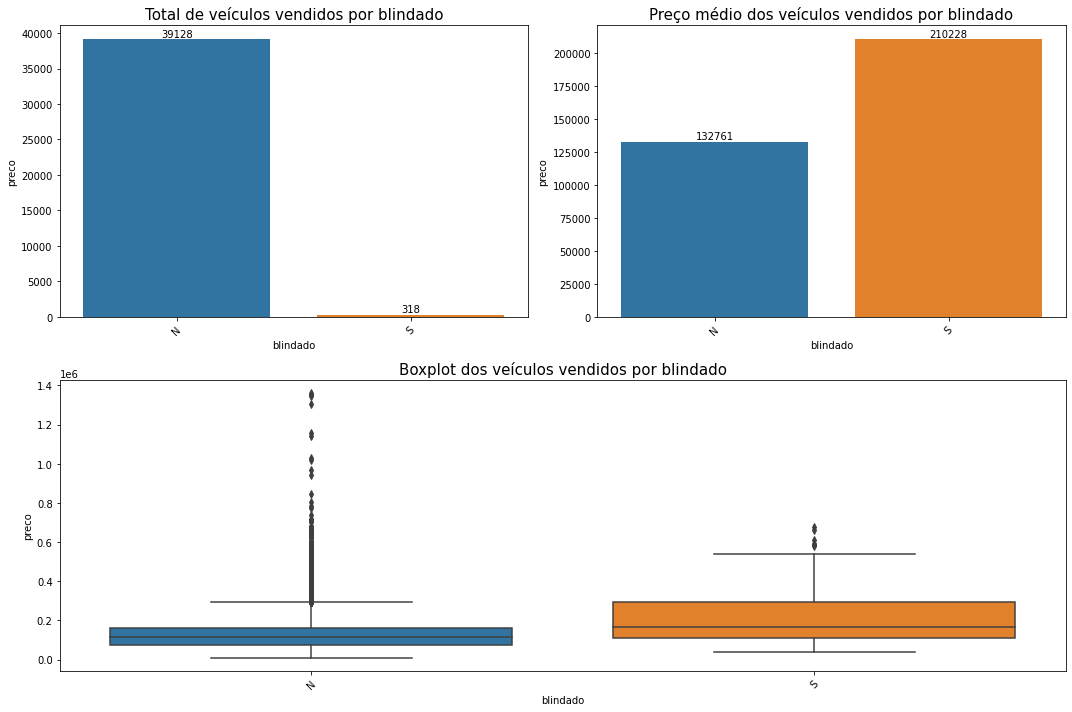

In [593]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por blindado', fontsize=15)
aux = df5[['blindado','preco']].groupby('blindado').count().reset_index().sort_values(by='blindado')
g = sns.barplot(x='blindado', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por blindado', fontsize=15)
aux = df5[['blindado','preco']].groupby('blindado').mean().reset_index().sort_values(by='blindado')
g = sns.barplot(x='blindado', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por blindado', fontsize=15)
aux = df5.sort_values(by='blindado')
sns.boxplot(x='blindado', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Cor

- Variável com muitas labels
- Encoding: **Target Encoding**

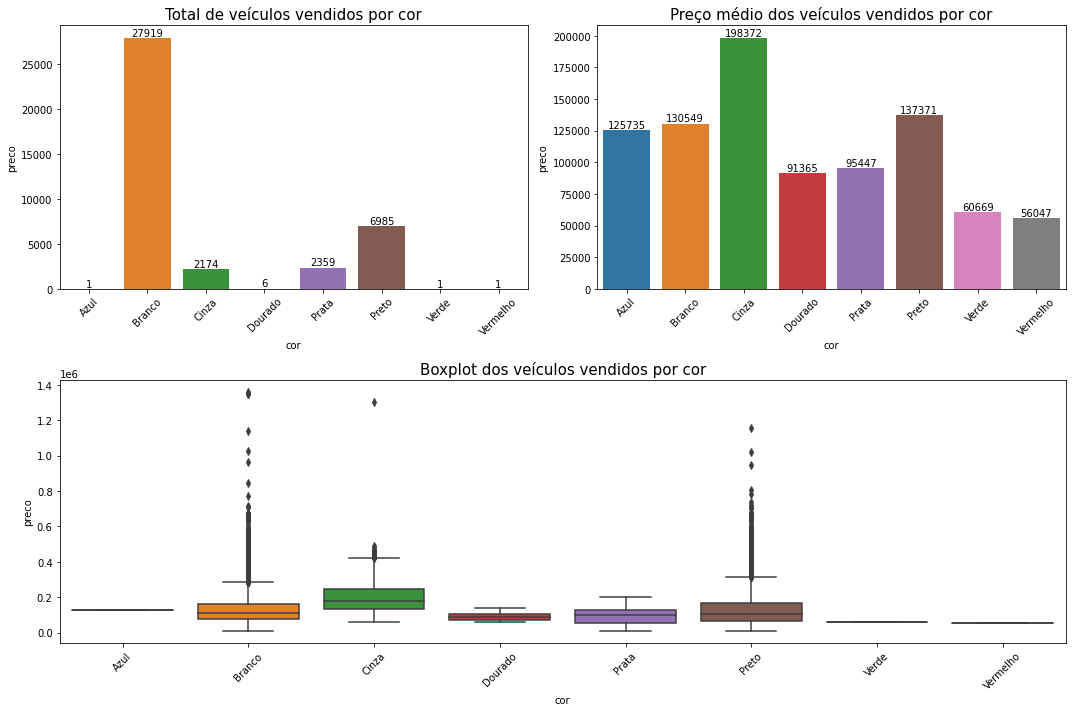

In [594]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cor', fontsize=15)
aux = df5[['cor','preco']].groupby('cor').count().reset_index().sort_values(by='cor')
g = sns.barplot(x='cor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cor', fontsize=15)
aux = df5[['cor','preco']].groupby('cor').mean().reset_index().sort_values(by='cor')
g = sns.barplot(x='cor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cor', fontsize=15)
aux = df5.sort_values(by='cor')
sns.boxplot(x='cor', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Tipo de Vendedor

- Variável com poucas labels. Representa uma ideia de estado (S ou N)
- Encoding: **One Hot Encoding**

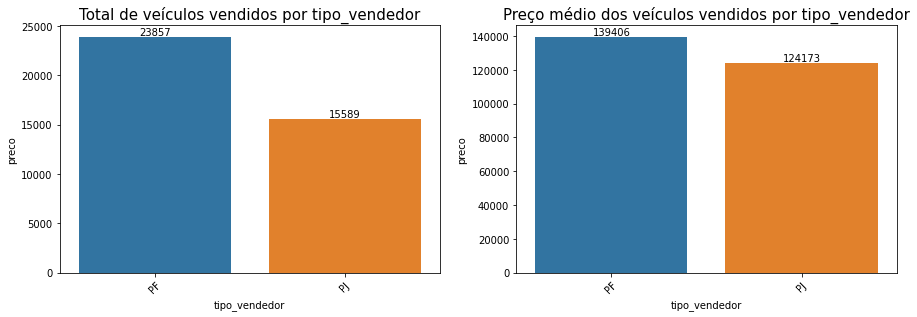

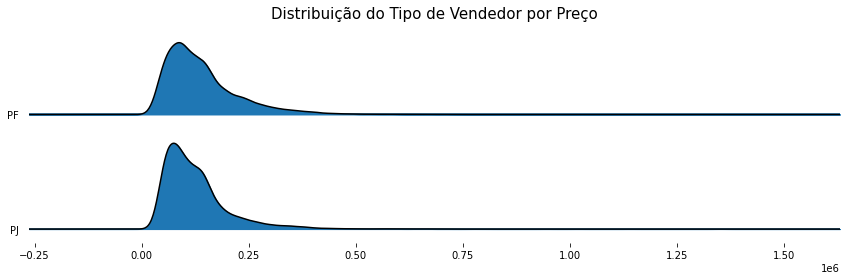

In [595]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo_vendedor', fontsize=15)
aux = df5[['tipo_vendedor','preco']].groupby('tipo_vendedor').count().reset_index().sort_values(by='tipo_vendedor')
g = sns.barplot(x='tipo_vendedor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo_vendedor', fontsize=15)
aux = df5[['tipo_vendedor','preco']].groupby('tipo_vendedor').mean().reset_index().sort_values(by='tipo_vendedor')
g = sns.barplot(x='tipo_vendedor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

# plt.subplot(grid[1,:])
# plt.title('Boxplot dos veículos vendidos por tipo_vendedor', fontsize=15)
# aux = df5.sort_values(by='tipo_vendedor')
# sns.boxplot(x='tipo_vendedor', y = 'preco', data=aux)
# plt.xticks(rotation=45);

joyplot(df5, by='tipo_vendedor', column='preco', figsize=(12,4))
plt.title('Distribuição do Tipo de Vendedor por Preço', fontsize=15)
plt.tight_layout()

#### Cidade do Vendedor

- Variável com muitos labels
- Encoding: **Target Enconde**

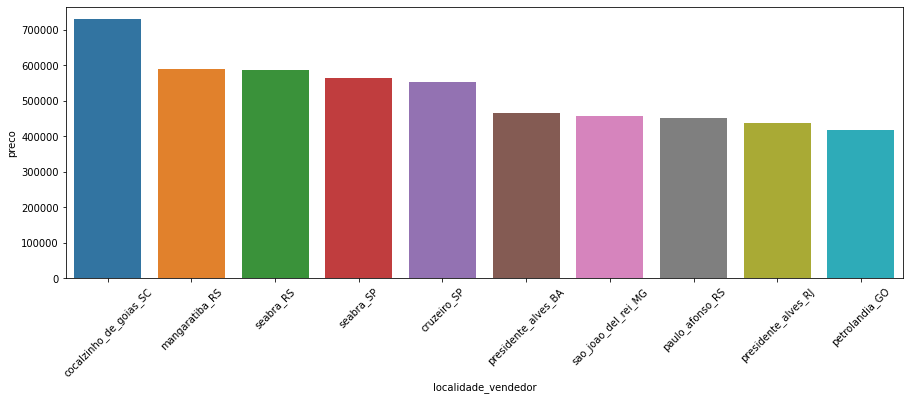

In [596]:
plt.figure(figsize=(15,5))
aux = df5[['localidade_vendedor','preco']].groupby('localidade_vendedor').mean().reset_index().sort_values(by='preco',ascending=False)[:10]
sns.barplot(x='localidade_vendedor', y = 'preco', data=aux)
plt.xticks(rotation=45);

#### Tipo de Anúncio

- Variáveis com labels que representam uma ideia de estado
- Encoding: **One Hot Encoding**

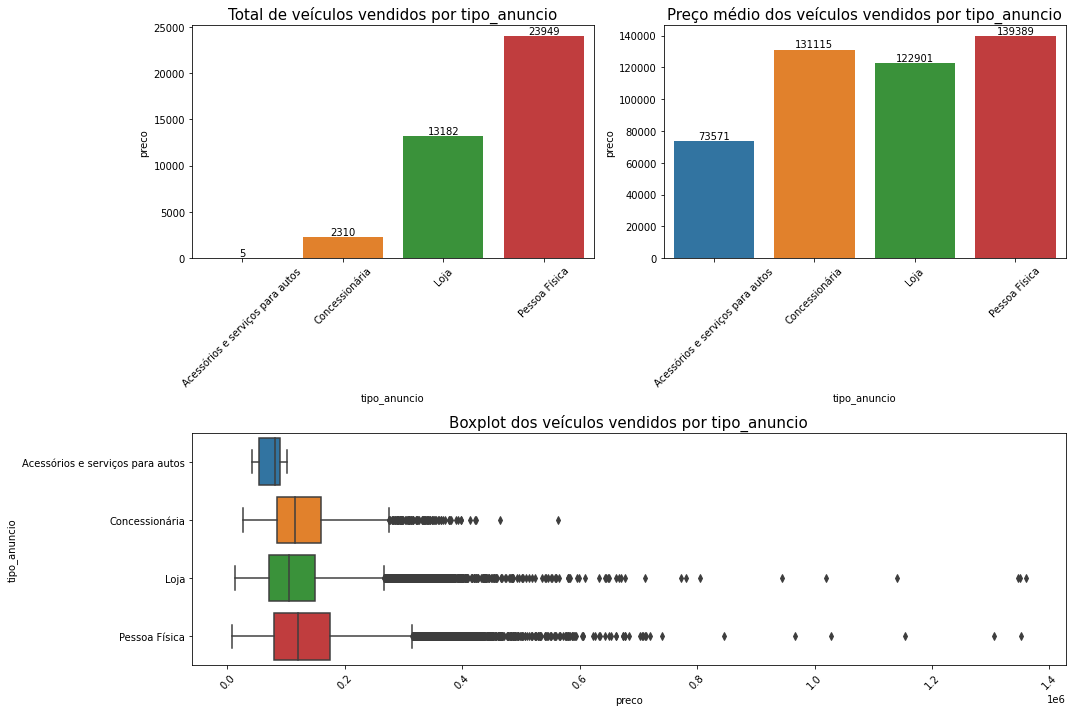

In [597]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5[['tipo_anuncio','preco']].groupby('tipo_anuncio').count().reset_index().sort_values(by='tipo_anuncio')
g = sns.barplot(x='tipo_anuncio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5[['tipo_anuncio','preco']].groupby('tipo_anuncio').mean().reset_index().sort_values(by='tipo_anuncio')
g = sns.barplot(x='tipo_anuncio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5.sort_values(by='tipo_anuncio')
sns.boxplot(x='preco', y = 'tipo_anuncio', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Entrega Delivery

- Variável binária
- Encoding: **One Hot Encoding**

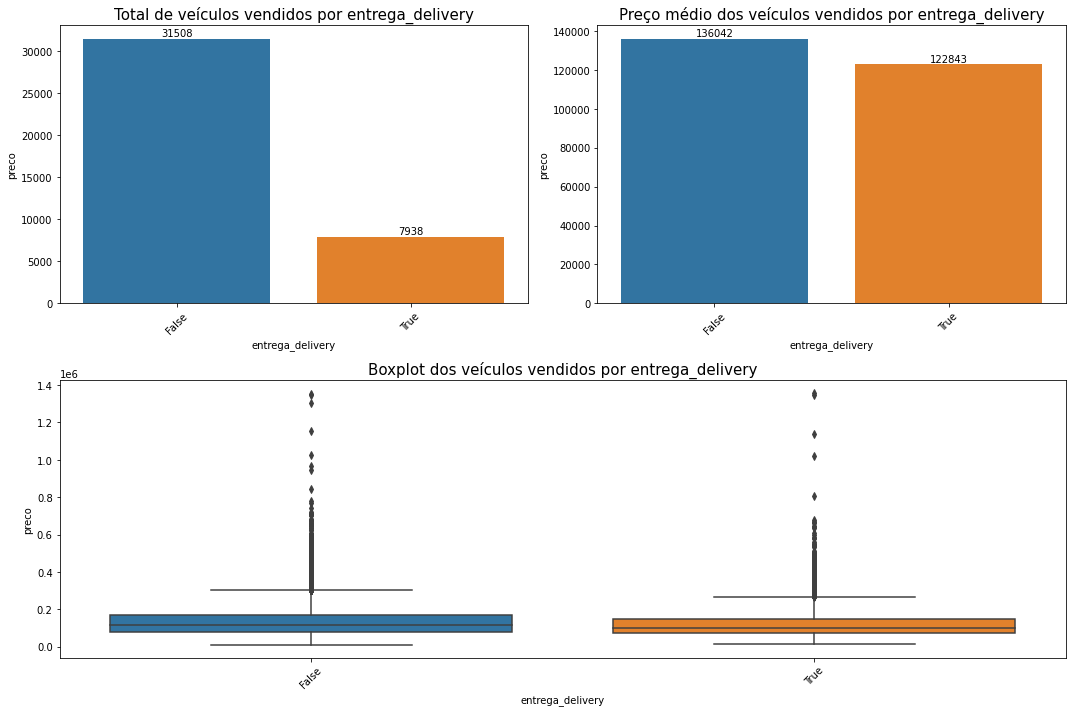

In [598]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por entrega_delivery', fontsize=15)
aux = df5[['entrega_delivery','preco']].groupby('entrega_delivery').count().reset_index().sort_values(by='entrega_delivery')
g = sns.barplot(x='entrega_delivery', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por entrega_delivery', fontsize=15)
aux = df5[['entrega_delivery','preco']].groupby('entrega_delivery').mean().reset_index().sort_values(by='entrega_delivery')
g = sns.barplot(x='entrega_delivery', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por entrega_delivery', fontsize=15)
aux = df5.sort_values(by='entrega_delivery')
sns.boxplot(x='entrega_delivery', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Troca

- Variável pouco significativa
- Remover

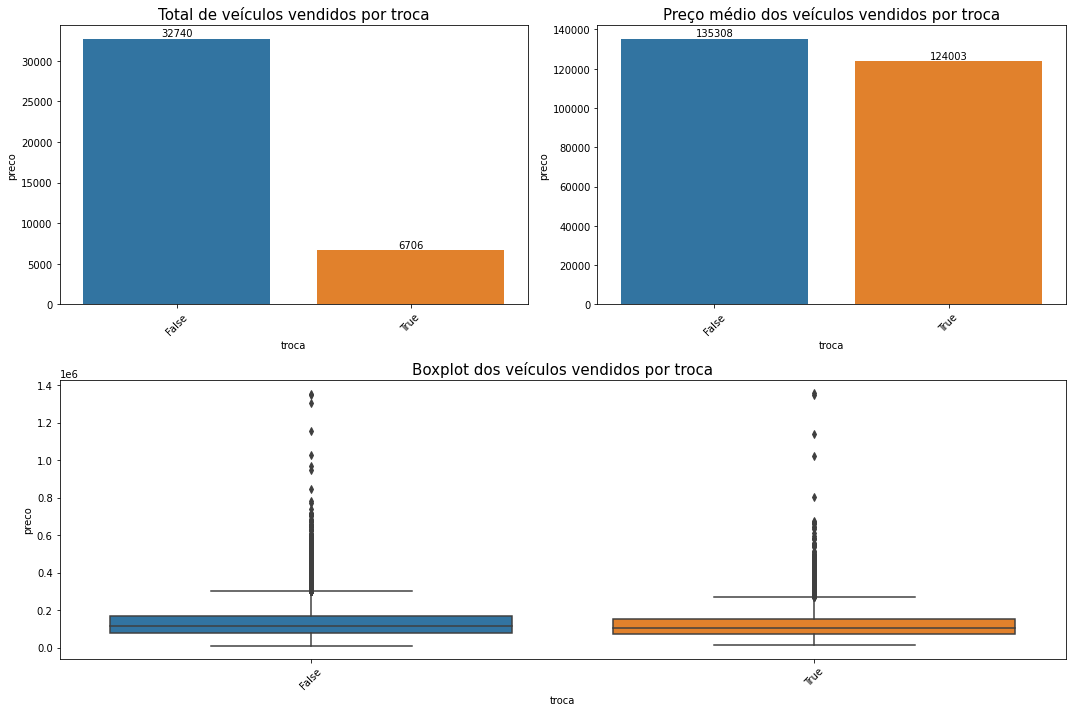

In [599]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por troca', fontsize=15)
aux = df5[['troca','preco']].groupby('troca').count().reset_index().sort_values(by='troca')
g = sns.barplot(x='troca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por troca', fontsize=15)
aux = df5[['troca','preco']].groupby('troca').mean().reset_index().sort_values(by='troca')
g = sns.barplot(x='troca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por troca', fontsize=15)
aux = df5.sort_values(by='troca')
sns.boxplot(x='troca', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Elegível revisão

- Variável pouco significativa
- Remover

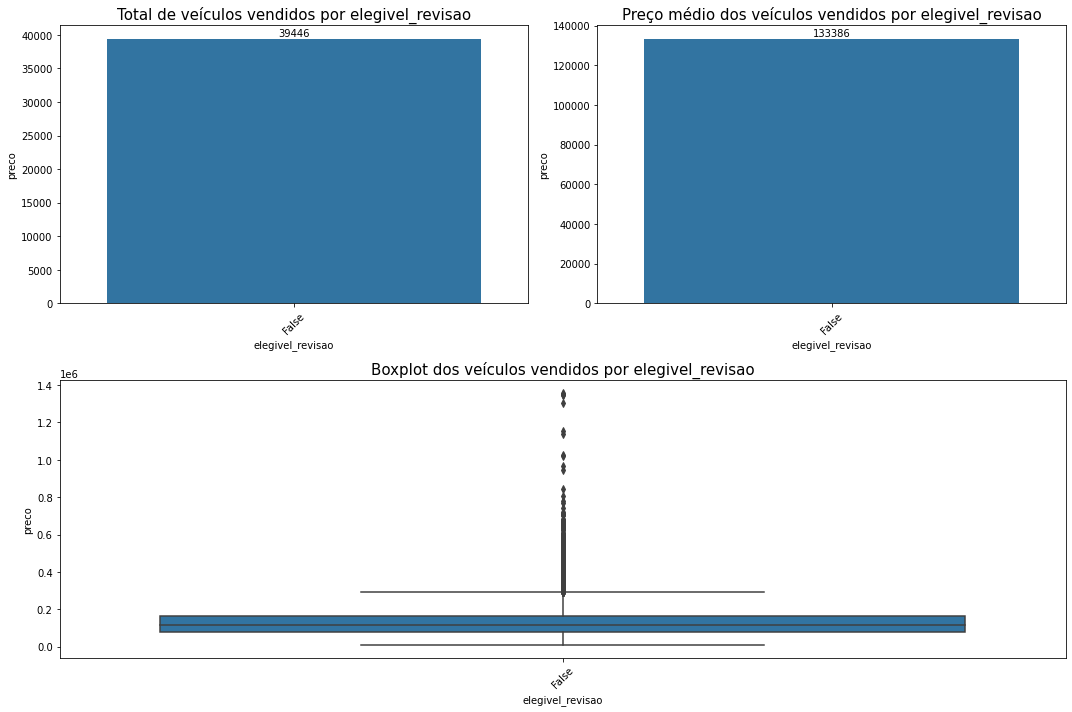

In [600]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5[['elegivel_revisao','preco']].groupby('elegivel_revisao').count().reset_index().sort_values(by='elegivel_revisao')
g = sns.barplot(x='elegivel_revisao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5[['elegivel_revisao','preco']].groupby('elegivel_revisao').mean().reset_index().sort_values(by='elegivel_revisao')
g = sns.barplot(x='elegivel_revisao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5.sort_values(by='elegivel_revisao')
sns.boxplot(x='elegivel_revisao', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Cilindradas

- Hipótese de que quanto mais raro o veículo com determinadas cilindradas, mais caro
- Encode: Frequency Encode

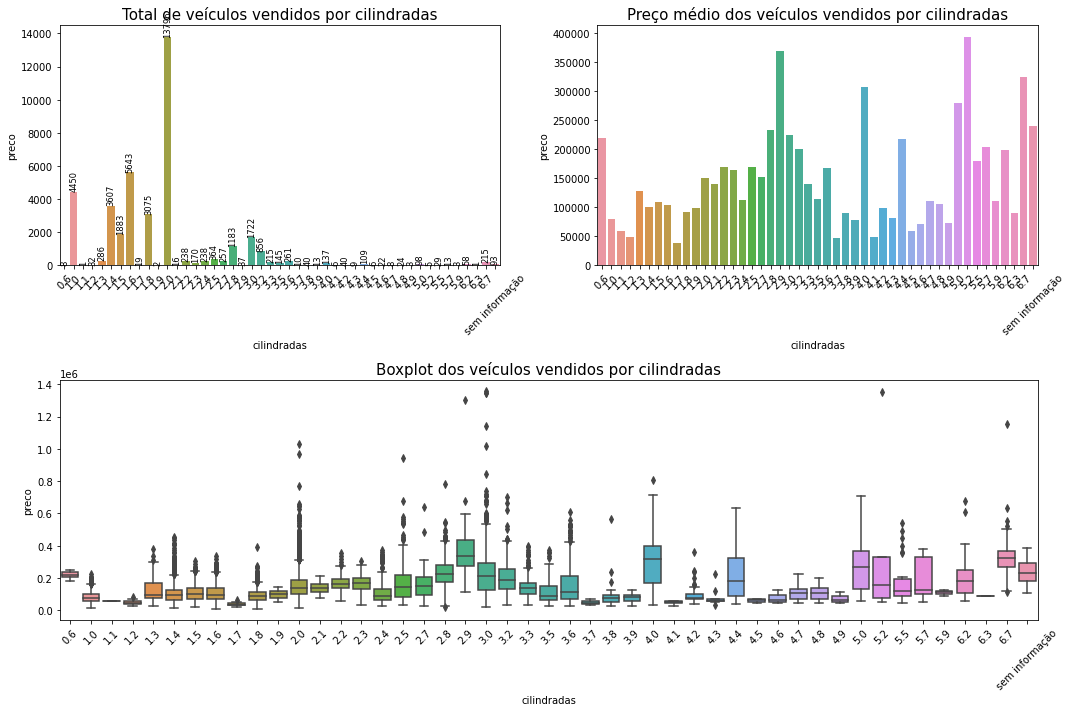

In [601]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cilindradas', fontsize=15)
aux = df5[['cilindradas','preco']].groupby('cilindradas').count().reset_index().sort_values(by='cilindradas')
g = sns.barplot(x='cilindradas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=90, fontsize='small')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cilindradas', fontsize=15)
aux = df5[['cilindradas','preco']].groupby('cilindradas').mean().reset_index().sort_values(by='cilindradas')
g = sns.barplot(x='cilindradas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cilindradas', fontsize=15)
aux = df5.sort_values(by='cilindradas')
sns.boxplot(x='cilindradas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Válvulas

- Variável com muitas labels
- Encoding: **Target Encoding**

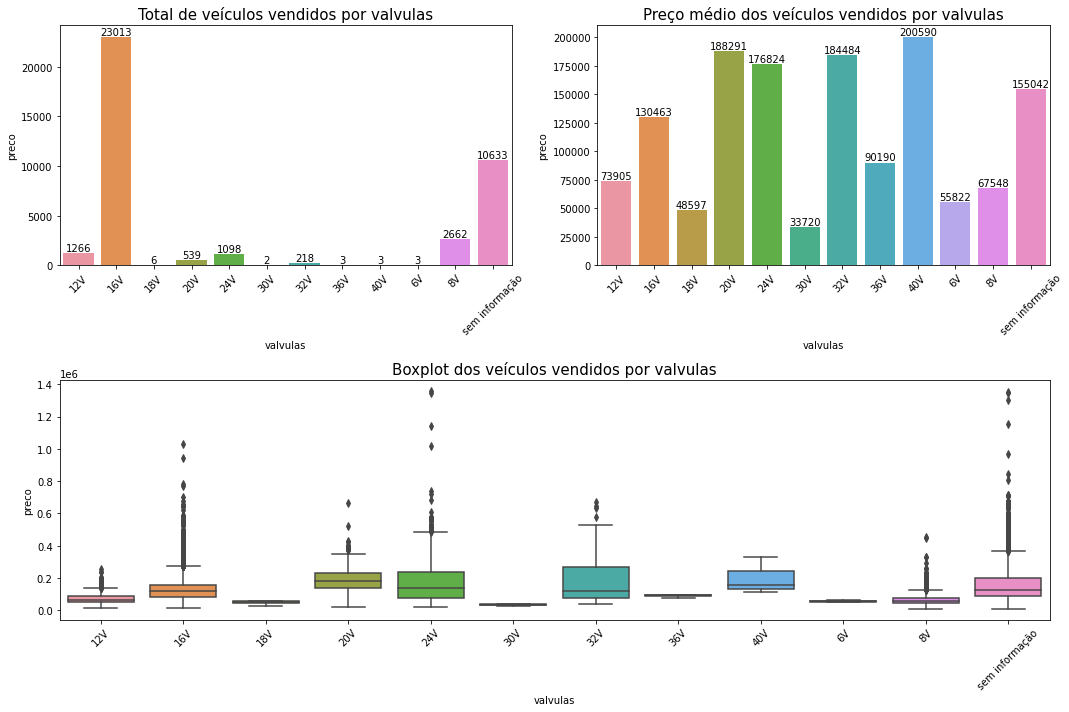

In [602]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por valvulas', fontsize=15)
aux = df5[['valvulas','preco']].groupby('valvulas').count().reset_index().sort_values(by='valvulas')
g = sns.barplot(x='valvulas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por valvulas', fontsize=15)
aux = df5[['valvulas','preco']].groupby('valvulas').mean().reset_index().sort_values(by='valvulas')
g = sns.barplot(x='valvulas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por valvulas', fontsize=15)
aux = df5.sort_values(by='valvulas')
sns.boxplot(x='valvulas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Combustivel

- Variável com muitas labels
- Encoding: **Frequency Encoding**

In [603]:
import matplotlib.gridspec as gridspec

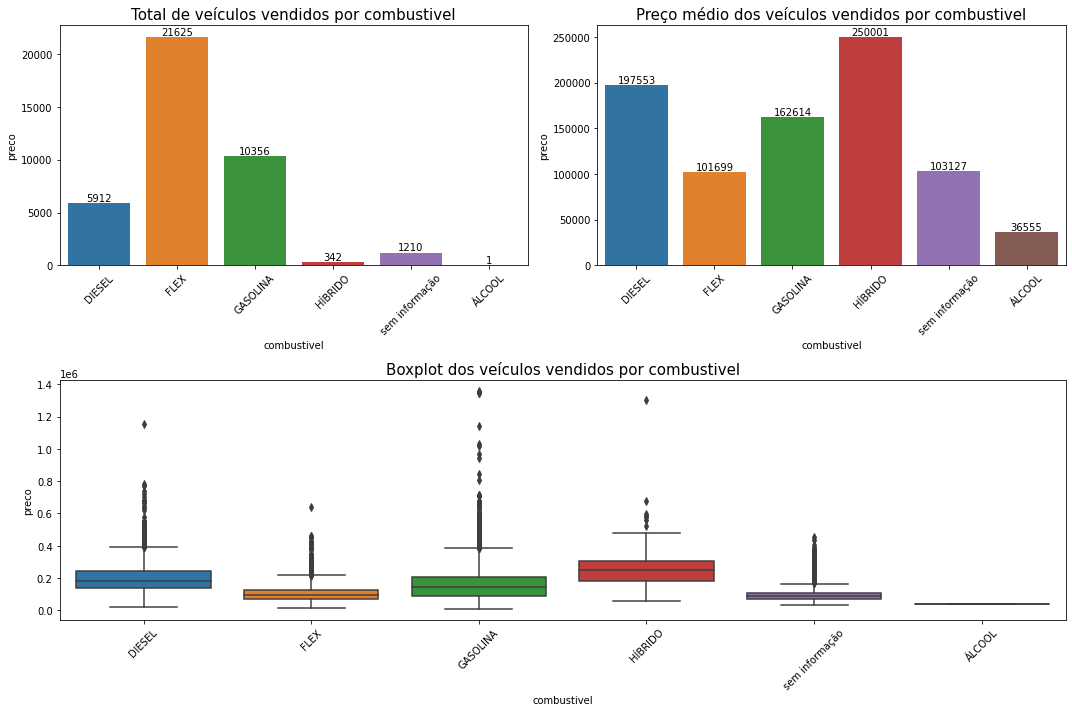

In [604]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por combustivel', fontsize=15)
aux = df5[['combustivel','preco']].groupby('combustivel').count().reset_index().sort_values(by='combustivel')
g = sns.barplot(x='combustivel', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por combustivel', fontsize=15)
aux = df5[['combustivel','preco']].groupby('combustivel').mean().reset_index().sort_values(by='combustivel')
g = sns.barplot(x='combustivel', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por combustivel', fontsize=15)
aux = df5.sort_values(by='combustivel')
sns.boxplot(x='combustivel', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

# Data Preparation

In [605]:
df6 = df5.copy()

In [606]:
X = df6.drop(columns=['preco'])
y = df6['preco']

## Split Dataset

In [607]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=0)

data_train = pd.concat([X_train,y_train], axis=1)
data_test = pd.concat([X_test,y_test], axis=1)

In [608]:
print(f'Treino: {X_train.shape[0]}')
print(f'Test: {X_test.shape[0]}')

Treino: 31556
Test: 7890


## Transformando variável resposta

In [609]:
y_train = pd.DataFrame(np.log1p(y_train))

## Standarization

In [610]:
sc = pp.StandardScaler()
y_train_norm= sc.fit_transform(y_train)
pickle.dump(sc, open('parameters/sc_response.pkl','wb'))

sc = pp.StandardScaler()
X_train['km_media_ano_em_1k_km'] = sc.fit_transform(X_train[['km_media_ano_em_1k_km']])
pickle.dump(sc, open('parameters/sc_km_media_ano.pkl','wb'))

In [611]:
X_train['km_media_ano_em_1k_km'].value_counts()

-0.091239    4118
 0.172780    3845
-0.355258    3547
 0.436800    3021
-0.619277    2739
 0.700819    2425
-0.883296    2173
 0.964838    1753
-1.147315    1585
-1.411335    1300
 1.228857    1147
-1.675354     764
 1.492876     738
 1.756896     482
-1.939373     403
 2.020915     285
 2.284934     256
-2.203392     202
-2.467411     181
 2.548953     161
 2.812972     133
 3.076992      72
 3.605030      45
 3.341011      40
 3.869049      38
 4.397087      19
 4.133068      17
 4.661107      17
 4.925126      13
 5.189145       8
 5.453164       7
 5.717183       7
 6.245222       5
 5.981203       4
 6.509241       2
 7.037279       1
 6.773260       1
 9.149433       1
 7.301299       1
Name: km_media_ano_em_1k_km, dtype: int64

## Rescaling

| Atributo               | Rescaling  |
| ---------------------- | ------------- |
|**ano_de_fabricação** | Robust Scaler |
|**ano_modelo:** | Robust Scaler|
|**odometro:** | Robust Scaler|
|**num_portas:** | Ordinal Encode|

### Robust Scaler

In [612]:
rs = pp.RobustScaler()

X_train['ano_de_fabricacao'] = rs.fit_transform(X_train[['ano_de_fabricacao']])
pickle.dump(rs, open('parameters/rs_ano_de_fabricacao.pkl','wb'))

X_train['ano_modelo'] = rs.fit_transform(X_train[['ano_modelo']])
pickle.dump(rs, open('parameters/rs_ano_modelo.pkl','wb'))

X_train['odometro'] = rs.fit_transform(X_train[['odometro']])
pickle.dump(rs, open('parameters/rs_odometro.pkl','wb'))

In [613]:
df6.columns

Index(['marca', 'modelo', 'versao', 'ano_de_fabricacao', 'ano_modelo',
       'odometro', 'cambio', 'num_portas', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'entrega_delivery', 'troca', 'elegivel_revisao', 'preco', 'cilindradas',
       'valvulas', 'combustivel', 'localidade_vendedor',
       'km_media_ano_em_1k_km', 'veiculo'],
      dtype='object')

## Encodings

| Atributo                | Encode          |
| ----------------------- | --------------- |
| **marca:**              | Frequency Encode| 
| **modelo:**             | Frequency Encode| 
| **versao:**             | Frequency Encode| 
| **cambio:**             | Ordinal Enconde| 
| **tipo:**               | Target Encode| 
| **blindado:**           | One Hot Encode| 
| **cor:**                | Target Encode| 
| **tipo_vendedor:**   | One Hot Encode| 
| **cidade_vendedor:** | Target Encode| 
| **tipo_anuncio:**   | One Hot Encode| 
| **cilindradas:**        | Frequency Encode| 
| **valvulas:**           | Target Encode| 
| **combustivel:**        | Target Encode| 

In [614]:
X_train['km_media_ano_em_1k_km'].value_counts()

-0.091239    4118
 0.172780    3845
-0.355258    3547
 0.436800    3021
-0.619277    2739
 0.700819    2425
-0.883296    2173
 0.964838    1753
-1.147315    1585
-1.411335    1300
 1.228857    1147
-1.675354     764
 1.492876     738
 1.756896     482
-1.939373     403
 2.020915     285
 2.284934     256
-2.203392     202
-2.467411     181
 2.548953     161
 2.812972     133
 3.076992      72
 3.605030      45
 3.341011      40
 3.869049      38
 4.397087      19
 4.133068      17
 4.661107      17
 4.925126      13
 5.189145       8
 5.453164       7
 5.717183       7
 6.245222       5
 5.981203       4
 6.509241       2
 7.037279       1
 6.773260       1
 9.149433       1
 7.301299       1
Name: km_media_ano_em_1k_km, dtype: int64

### One Hot Encode

In [615]:
# blindado
X_train['blindado'] = X_train['blindado'].replace({'S':1, 'N':0})

# tipo_vendedor
X_train['tipo_vendedor'] = X_train['tipo_vendedor'].replace({'PJ':1, 'PF':0})

# tipo_anuncio
oe = pp.OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train['tipo_anuncio'] = X_train['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
cols_dummies = oe.fit_transform(X_train['tipo_anuncio'].values.reshape(-1,1))
X_train[oe.categories_[0]] = cols_dummies
pickle.dump(oe,open(f'parameters/oe_tipo_anuncio.pkl', 'wb'))

X_train['cambio'] = X_train['cambio'].map({'Manual':0,
                                            'Automática Sequencial':1, 
                                            'Semi-automática':2,
                                            'CVT':3,
                                            'Automatizada':4,
                                            'Automática':4,
                                            'Automatizada DCT':5
                                            })

X_train['num_portas'] = X_train['num_portas'].apply(lambda x: 1 if x > 2 else 0)

In [616]:
X_train

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,...,cilindradas,valvulas,combustivel,localidade_vendedor,km_media_ano_em_1k_km,veiculo,acessorios_e_servicos_para_autos,concessionaria,loja,pessoa_fisica
11966,PEUGEOT,3008,GRIFFE PACK THP 4P,0.25,0.50,-0.594145,4,1,Utilitário esportivo,0,...,1.6,16V,GASOLINA,goiania_GO,-0.619277,PEUGEOT_3008_7,0.0,0.0,0.0,1.0
10300,FORD,ECOSPORT,TI-VCT SE,0.50,0.50,0.104796,4,1,Sedã,0,...,1.5,sem informação,FLEX,sao_jose_do_rio_preto_SP,1.756896,FORD_ECOSPORT_16,0.0,0.0,1.0,0.0
10009,FIAT,TORO,EVO FREEDOM AT6,0.25,0.50,-0.060913,4,1,Picape,0,...,1.8,16V,FLEX,sao_paulo_SP,1.228857,FIAT_TORO_14,0.0,0.0,1.0,0.0
30671,CHEVROLET,JOY,SPE4,0.25,0.50,-0.735776,0,1,Hatchback,0,...,1.0,sem informação,FLEX,rio_de_janeiro_RJ,-1.147315,CHEVROLET_JOY_5,0.0,0.0,0.0,1.0
32870,FORD,RANGER,XLS 4X4 CD 4P,-0.25,0.00,0.946982,4,1,Picape,0,...,2.2,16V,DIESEL,medianeira_PR,2.284934,FORD_RANGER_18,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,PEUGEOT,3008,GRIFFE PACK THP 4P,0.25,0.50,-0.512757,4,1,Sedã,0,...,1.6,16V,GASOLINA,recife_MG,-0.355258,PEUGEOT_3008_8,0.0,1.0,0.0,0.0
32103,JEEP,COMPASS,LIMITED,0.50,0.75,-0.727704,4,1,Sedã,0,...,2.0,16V,FLEX,sao_paulo_SP,-0.619277,JEEP_COMPASS_7,0.0,1.0,0.0,0.0
30403,TOYOTA,COROLLA,GLI UPPER 4P,0.00,0.00,-0.117415,4,1,Sedã,0,...,1.8,16V,FLEX,praia_grande_SP,-0.091239,TOYOTA_COROLLA_9,0.0,0.0,1.0,0.0
21243,MITSUBISHI,OUTLANDER,GT 4X4 V6 4P,0.00,0.00,-0.066583,4,1,Sedã,0,...,3.0,24V,GASOLINA,sao_jose_do_rio_preto_SP,-0.091239,MITSUBISHI_OUTLANDER_9,0.0,0.0,0.0,1.0


### Target Enconde

In [617]:
for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
    te = ce.TargetEncoder(cols=[att]).fit(X_train, y_train_norm)
    pickle.dump(te, open(f'parameters/te_{att}.pkl','wb'))
    X_train = te.transform(X_train)

### Frequency Encode

In [618]:
for att in ['marca', 'modelo','versao','cilindradas']:
    fe =  ce.CountEncoder(cols=[att], normalize=True).fit(X_train)
    pickle.dump(fe,open(f'parameters/fe_{att}.pkl', 'wb'))
    X_train = fe.transform(X_train)

# Test Preparation

In [620]:
# Transformando variável resposta
y_test = pd.DataFrame(np.log1p(y_test))

sc = pickle.load(open('parameters/sc_km_media_ano.pkl','rb'))
X_test['km_media_ano_em_1k_km'] = sc.transform(X_test[['km_media_ano_em_1k_km']])

# Rescaling
rs = pickle.load(open('parameters/rs_ano_de_fabricacao.pkl','rb'))
X_test['ano_de_fabricacao'] = rs.transform(X_test[['ano_de_fabricacao']])

rs = pickle.load(open('parameters/rs_ano_modelo.pkl','rb'))
X_test['ano_modelo'] = rs.transform(X_test[['ano_modelo']])

rs = pickle.load(open('parameters/rs_odometro.pkl','rb'))
X_test['odometro'] = rs.transform(X_test[['odometro']])

# Encode
## One Hot Encode
# blindado
X_test['blindado'] = X_test['blindado'].replace({'S':1, 'N':0})

# tipo_vendedor
X_test['tipo_vendedor'] = X_test['tipo_vendedor'].replace({'PJ':1, 'PF':0})

# tipo_anuncio
oe = pickle.load(open(f'parameters/oe_tipo_anuncio.pkl', 'rb'))
X_test['tipo_anuncio'] = X_test['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
cols_dummies = oe.transform(X_test['tipo_anuncio'].values.reshape(-1,1))
X_test[oe.categories_[0]] = cols_dummies


X_test['cambio'] = X_test['cambio'].map({'Manual':0,
                                            'Automática Sequencial':1, 
                                            'Semi-automática':2,
                                            'CVT':3,
                                            'Automatizada':4,
                                            'Automática':4,
                                            'Automatizada DCT':5
                                            })

X_test['num_portas'] = X_test['num_portas'].apply(lambda x: 1 if x > 2 else 0)

## Target Encode
for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
    te = pickle.load(open(f'parameters/te_{att}.pkl','rb'))
    X_test = te.transform(X_test,)
    
## Frequency Encode

for att in ['marca', 'modelo','versao','cilindradas']:
    fe = pickle.load(open(f'parameters/fe_{att}.pkl', 'rb'))
    X_test = fe.transform(X_test)

In [621]:
X_test.sample(3)

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,...,cilindradas,valvulas,combustivel,localidade_vendedor,km_media_ano_em_1k_km,veiculo,acessorios_e_servicos_para_autos,concessionaria,loja,pessoa_fisica
12550,0.068101,0.050196,0.002250,0.25,0.5,-0.677009,4,1,-0.112989,0,...,0.350583,0.032428,0.806930,0.203562,-0.883296,0.559876,0.0,1.0,0.0,0.0
37501,0.074217,0.021739,0.008239,-0.25,0.0,-0.355101,4,1,0.270429,0,...,0.030074,0.032428,0.806930,-0.109547,-0.619277,1.169448,0.0,0.0,0.0,1.0
18439,0.063570,0.013943,0.000222,-1.25,-1.0,0.330118,0,1,0.270429,0,...,0.078052,0.032428,-0.376268,-0.116644,-0.619277,-0.483086,0.0,0.0,1.0,0.0


# Feature Selection

In [622]:
features = [
'veiculo',
'km_media_ano_em_1k_km',
'marca',
'modelo',
'versao',
'ano_de_fabricacao',
'ano_modelo',
'odometro',
'cambio',
'num_portas',
'tipo',
'blindado',
'cor',
'tipo_vendedor',
'cilindradas',
'valvulas',
'combustivel',
'localidade_vendedor',
'acessorios_e_servicos_para_autos',
'concessionaria',
'loja',
'pessoa_fisica'
]

In [623]:
# # define a Random Rorest
# rf = en.RandomForestRegressor(n_jobs=-1)

# # define a Boruta instance
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 0 )

# # train Boruuta
# boruta_result = boruta.fit(X_train[features].values, y_train.values)

In [624]:
# # list boolean with columns selected
# cols_selected = boruta_result.support_.tolist()

# # columns name selected
# features_selected = X_train[features].iloc[:, cols_selected].columns.tolist()

In [625]:
features_selected = [
'veiculo',
'marca',
'km_media_ano_em_1k_km',
'modelo',
'versao',
'ano_de_fabricacao',
'ano_modelo',
'odometro',
'cambio',
'tipo',
'cilindradas',
'combustivel',
'localidade_vendedor'
]

In [626]:
# # features vs importantes dataframe
# aux = pd.DataFrame(zip(features, rf.feature_importances_)).sort_values(by=1, ascending=False).rename(columns={0:'feature',1:'importance'})

# dict_cores = {}
# for col in features:
#     if col in features_selected:
#         dict_cores[col] = 'forestgreen'
#     else:
#         dict_cores[col] = 'royalblue'

# # plot
# plt.figure(figsize=(10,7))
# plt.title('Importancia das Features')
# sns.barplot(y='feature',x='importance', data=aux,palette=dict_cores);
# plt.legend(['Selected','Not Selected']);

# Machine Learning Model

In [627]:
X_train['km_media_ano_em_1k_km'].unique()

array([-0.6192771 ,  1.75689559,  1.22885721, -1.14731548,  2.28493396,
       -0.35525791, -0.09123873,  1.4928764 , -1.41133466,  0.43679965,
        2.02091477,  0.17278046, -1.67535385,  0.70081884, -0.88329629,
        0.96483802,  2.81297234, -1.93937304,  3.86904909, -2.20339223,
        2.54895315,  3.07699152, -2.46741141,  3.6050299 ,  3.34101071,
        4.13306827,  4.92512584,  5.45316421,  4.39708746,  5.18914502,
        5.7171834 ,  4.66110665,  6.24522177,  5.98120259,  7.03727934,
        6.77326015,  6.50924096,  9.14943284,  7.30129852])

## Linear Regression

In [628]:
# define model
lm_model = lm.LinearRegression()

# fit model
lm_model.fit(X_train[features_selected], y_train)

# predict
y_pred = lm_model.predict(X_test[features_selected])

# performance
ml_error('Linear Model', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,Linear Model,32183.879168,0.262018,50984.566929


### Linear Model Cross Validation

In [629]:
# cv_linear_model = cross_validation_k_fold(X, y, features_selected, 'Linear Model', lm_model, 10)
# cv_linear_model

## Lasso

In [630]:
# model definition
lasso_model = lm.Lasso(alpha=0.01)

# fit model
lasso_model.fit(X_train[features_selected], y_train)

# predict
y_pred = lasso_model.predict(X_test[features_selected])

# performance
ml_error('Lasso', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,Lasso,32603.492404,0.267173,51969.657284


### Lasso Cross Validation

In [631]:
# cv_lasso = cross_validation_k_fold(X, y, features_selected, 'Lasso', lasso_model, 10)
# cv_lasso 

## Random Forest

In [632]:
# model definition
rf_model = en.RandomForestRegressor(n_jobs=-1, random_state=0)

# model fit
rf_model.fit(X_train[features_selected], y_train)

# predict
y_pred = rf_model.predict(X_test[features_selected])

# performance
ml_error('Random Forest', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,Random Forest,27548.15258,0.226466,43407.383103


###  Random Forest Cross Validation

In [633]:
# cv_rf = cross_validation_k_fold(X, y, features_selected, 'Random Forest', rf_model, 10)
# cv_rf

## XGBoost

In [634]:
# model definition
xgb_model = xgboost.XGBRegressor(n_jobs = -1 , random_state=0)

# model fit
xgb_model.fit(X_train[features_selected], y_train)

# predict
y_pred = xgb_model.predict(X_test[features_selected])

# performance
ml_error('XGboost', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,XGboost,26743.419511,0.218336,42933.001347


In [635]:
X_train

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,...,cilindradas,valvulas,combustivel,localidade_vendedor,km_media_ano_em_1k_km,veiculo,acessorios_e_servicos_para_autos,concessionaria,loja,pessoa_fisica
11966,0.056629,0.003201,0.002884,0.25,0.50,-0.594145,4,1,1.052072,0,...,0.141146,0.032428,0.329538,0.448480,-0.619277,5.870042e-01,0.0,0.0,0.0,1.0
10300,0.036792,0.010204,0.007796,0.50,0.50,0.104796,4,1,-0.112989,0,...,0.047028,0.246758,-0.376268,0.390263,1.756896,-1.406626e+00,0.0,0.0,1.0,0.0
10009,0.063570,0.029408,0.013436,0.25,0.50,-0.060913,4,1,0.270429,0,...,0.078052,0.032428,-0.376268,-0.116644,1.228857,1.264773e-02,0.0,0.0,1.0,0.0
30671,0.102199,0.003708,0.003613,0.25,0.50,-0.735776,0,1,-0.605672,0,...,0.113893,0.246758,-0.376268,0.018602,-1.147315,-2.229171e-15,0.0,0.0,0.0,1.0
32870,0.036792,0.010426,0.000570,-0.25,0.00,0.946982,4,1,0.270429,0,...,0.005894,0.032428,0.806930,0.203562,2.284934,4.439897e-01,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,0.056629,0.003201,0.002884,0.25,0.50,-0.512757,4,1,-0.112989,0,...,0.141146,0.032428,0.329538,-0.040253,-0.355258,6.016163e-01,0.0,1.0,0.0,0.0
32103,0.068101,0.050196,0.034573,0.50,0.75,-0.727704,4,1,-0.112989,0,...,0.350583,0.032428,-0.376268,-0.116644,-0.619277,4.448923e-01,0.0,1.0,0.0,0.0
30403,0.074217,0.030454,0.002979,0.00,0.00,-0.117415,4,1,-0.112989,0,...,0.078052,0.032428,-0.376268,-0.541330,-0.091239,-3.543254e-01,0.0,0.0,1.0,0.0
21243,0.029630,0.006179,0.000761,0.00,0.00,-0.066583,4,1,-0.112989,0,...,0.043161,0.319211,0.329538,0.390263,-0.091239,6.970135e-02,0.0,0.0,0.0,1.0


### XGboost Cross Validation

In [636]:
# cv_xgboost = cross_validation_k_fold(X, y, features_selected, 'XGBoost', xgb_model, 10)
# cv_xgboost

In [637]:
# cv_results = pd.concat([cv_linear_model, cv_lasso, cv_rf, cv_xgboost], axis = 0)

In [638]:
# cv_results

| Model Name    | MAE                   | MAPE              | RMSE                  |
| ------------- | --------------------- | ----------------- | ----------------------|
| Linear Model	| 37667.85 +/- 335.86	| 0.301 +/- 0.005	| 59134.285 +/- 1231.935| 
| Lasso	        | 38169.365 +/- 402.47	| 0.306 +/- 0.003	| 59956.966 +/- 1215.744| 
| Random Forest	| 27898.101 +/- 474.117	| 0.224 +/- 0.003	| 45092.349 +/- 527.615| 
| XGBoost	    | 28317.317 +/- 695.562	| 0.229 +/- 0.004	| 45331.559 +/- 1651.685| 

# Business Performance

- Para avaliar a performance do modelo em termo de negócio, ou seja, o quanto de economia ele é capaz de gerar através das melhores decisões que serão tomadas, vamos comparar as previsões do modelo com o preço médio dos automáveis vendidos por região, marca e ano quilometragem

In [682]:
# criando feature de km médio rodado por ano
df5['km_media_ano_em_1k_km'] = df5['odometro']/np.round(2023 - df5['ano_modelo'] + 0.51,0)
# arredondando e escalando por 1000 km
df5['km_media_ano_em_1k_km'] = round(df5['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

# criando feature de agregação do veículo com marca, modelo, km_media e localidade
df5['veiculo'] = df5['marca'].astype(str) + "_" + df5['modelo'].astype(str) + "_" + df5['km_media_ano_em_1k_km'].astype(str)

In [683]:
# separando treino e teste
X_train, X_prod, y_train, y_prod = ms.train_test_split(df5.drop('preco', axis=1), df5['preco'], test_size=0.2, random_state=0)

data_train = pd.concat([X_train,y_train], axis=1)
data_prod = pd.concat([X_prod,y_prod], axis=1)

## Baseline

In [684]:
# calculando preço médio dos veículos
precos_medios = data_train[['veiculo','preco']].groupby('veiculo')['preco'].mean()

# incluindo no dataframe
data_prod['precos_medios'] = data_prod['veiculo'].map(precos_medios)

# preenchendo valores nulos
data_prod['precos_medios'] = data_prod['precos_medios'].fillna(data_train['preco'].mean())

## Modelo

In [685]:
# transformando dataset de treino para refazer encodes e scalers
X_train_transformed, y_train_transformed = train_preparation(X_train, y_train)

# transformando dataset de produção para aplicação do modelo
X_prod_transformed, y_test_transformed = test_preparation(X_prod, y_prod)

# fazendo predição
y_pred = xgb_model.predict(X_prod_transformed[features_selected])
y_pred = np.expm1(y_pred)

# inserindo o dataframe
data_prod['preco_modelo'] = y_pred

## Comparação entre o Baseline e o Modelo

In [686]:
ml_error('Baseline', data_prod['preco'], data_prod['precos_medios'])

,Model Name,MAE,MAPE,RMSE
0,Baseline,37165.416141,0.34319,55687.082029


In [687]:
ml_error('Model', data_prod['preco'], data_prod['preco_modelo'])

,Model Name,MAE,MAPE,RMSE
0,Model,26743.419511,0.218336,42933.001347


In [710]:
preco_por_modelo = data_prod[['marca', 'modelo', 'preco','precos_medios','preco_modelo']].groupby(['marca','modelo']).apply(lambda x: mt.mean_absolute_error(x['preco'], x['precos_medios'])).reset_index().rename(columns={0:'MAE_baseline'})

preco_por_modelo['veiculo'] = preco_por_modelo['marca'] + '_' + preco_por_modelo['modelo']

aux1 = data_prod[['marca', 'modelo', 'preco','precos_medios','preco_modelo']].groupby(['marca','modelo']).apply(lambda x: mt.mean_absolute_error(x['preco'], x['preco_modelo'])).reset_index().rename(columns={0:'MAE_modelo'})

aux1['veiculo'] = aux1['marca'] + '_' + aux1['modelo']

preco_por_modelo = pd.merge(preco_por_modelo, aux1[['veiculo','MAE_modelo']], on = 'veiculo', how='left')

In [712]:
preco_por_modelo['diff_MAE'] = preco_por_modelo['MAE_baseline'] - preco_por_modelo['MAE_modelo']

In [719]:
preco_por_modelo.sort_values('MAE_modelo')

,marca,modelo,MAE_baseline,veiculo,MAE_modelo,diff_MAE
221,MERCEDES-BENZ,E 350,14058.221469,MERCEDES-BENZ_E 350,490.077714,13568.143756
204,MERCEDES-BENZ,C 280,19184.039192,MERCEDES-BENZ_C 280,895.335584,18288.703608
86,CITROËN,C4 CACTUS,1653.441557,CITROËN_C4 CACTUS,1497.905116,155.536441
57,CHEVROLET,BLAZER,71977.703946,CHEVROLET_BLAZER,1706.154763,70271.549183
289,RAM,1500,76412.759012,RAM_1500,2080.829550,74331.929462
...,...,...,...,...,...,...
36,BMW,M2,205063.133038,BMW_M2,172701.859984,32361.273055
287,PORSCHE,PANAMERA,163598.205234,PORSCHE_PANAMERA,184191.364292,-20593.159058
241,MERCEDES-BENZ,S 560,380275.893883,MERCEDES-BENZ_S 560,193746.388379,186529.505505
283,PORSCHE,911,310794.337307,PORSCHE_911,243418.849290,67375.488017


In [714]:
preco_por_modelo['diff_MAE'].sum()

6688456.640449587

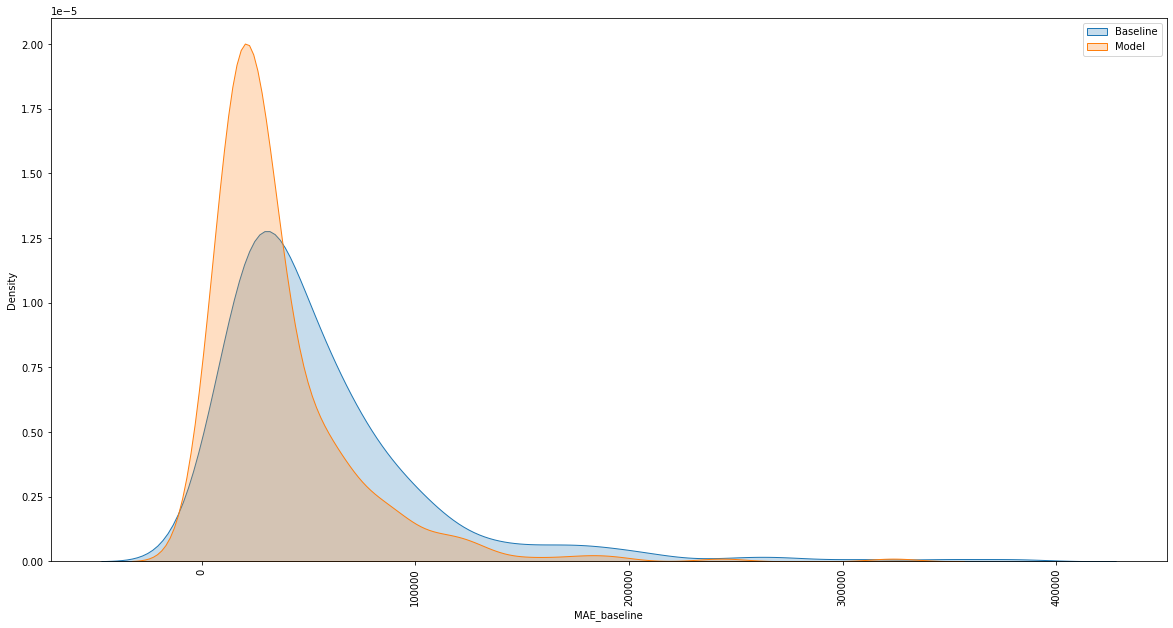

In [723]:
plt.figure(figsize=(20,10))
sns.kdeplot(x='MAE_baseline', data=preco_por_modelo,shade=True)
sns.kdeplot(x='MAE_modelo', data=preco_por_modelo,shade=True)
plt.legend(['Baseline','Model'])
plt.xticks(rotation=90);